<center> <h1>Dashboard DataCoders</h1> </center>

In [122]:
sc.stop()

In [123]:
import matplotlib.pyplot as plt
import pandas as pd 
import findspark

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from matplotlib.pyplot import figure

findspark.init()
APP_NAME = "DATATON"
conf = SparkConf().setAppName(APP_NAME) 
conf = conf.setMaster("local[*]")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.appName(APP_NAME).getOrCreate() 

In [124]:
schema = StructType([
    StructField("id_trx",    StringType(), True),
    StructField("id_client", StringType(), True),
    StructField("fecha",     StringType(), True),
    StructField("hora",      StringType(), True),
    StructField("valor_trx", DoubleType(),  True),
    StructField("categoria", StringType(), True)])

df = spark.read.load("pse.csv",
                     format="csv", 
                     sep=",", 
                     schema=schema, 
                     header="false")

df.createOrReplaceTempView("tabla")

### Número de transacciones por número de categorías por compra

In [126]:
sql = spark.sql(
                """
                SELECT cat, COUNT(*)
                FROM (
                    SELECT id_client, COUNT(*) as cat
                    FROM ( 
                        SELECT DISTINCT id_client,categoria
                        FROM tabla
                    )
                    GROUP BY id_client
                )
                GROUP BY cat
                ORDER BY cat
                 """
               )

!rm -rf demo
sql.write.save('tables/demo', format="csv")
!cat tables/demo/part* > dashboard/clientes_categoria.csv
!rm -rf demo

/bin/sh: 1: cannot create dashboard/clientes_categoria.csv: Directory nonexistent


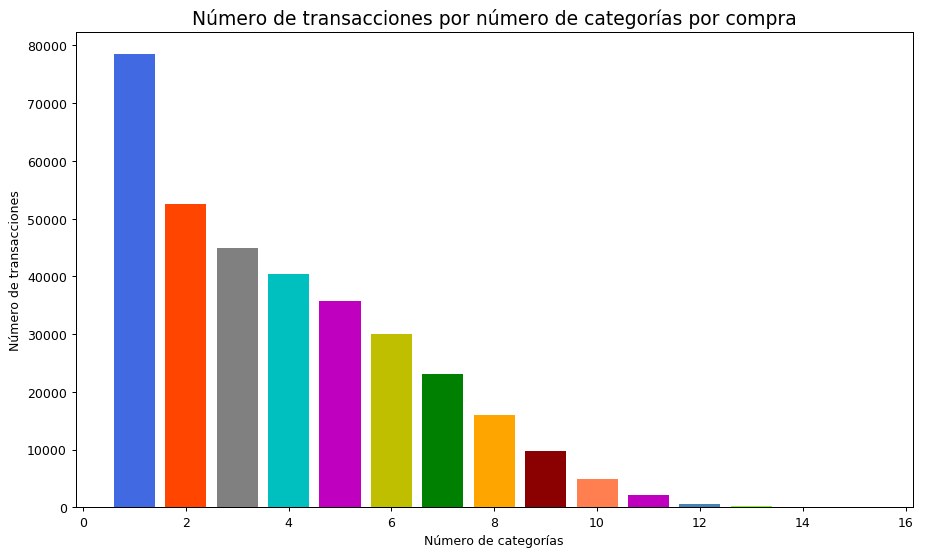

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig = figure(num=None, figsize=(12, 7), dpi=90, facecolor='w', edgecolor='k')

df = pd.read_csv('graficos_dashboard/clientes_categoria.csv', header=None, names=None)

ax = fig.add_subplot(111)
ax.set_title('Número de transacciones por número de categorías por compra',fontsize=15)
ax.set_xlabel('Número de categorías')
ax.set_ylabel('Número de transacciones')

colors = ['royalblue', 'orangered', 'gray', 'c', 'm', 'y', 'g','orange', 'darkred', 'coral', 'm', 'steelblue', 'chartreuse', 'r','magenta']

#ax.grid(color='b', linewidth=0.1)

plt.bar(df[0].tolist(),df[1].tolist(),color=colors)

plt.show()


____

### Valor total de las transacciones por número de categorías por cliente

In [131]:
sql = spark.sql(
                """ 
                SELECT CAT,sum(suma2) as total
                FROM(
                    SELECT COUNT(*) as CAT ,SUM(suma) as suma2
                    FROM (
                        SELECT id_client,categoria,SUM(valor_trx) as suma 
                        FROM tabla
                        GROUP BY id_client,categoria
                        ORDER BY id_client                    
                    ) GROUP BY id_client
                ) GROUP BY CAT
                  ORDER BY CAT         
                 """
               )

!rm -rf demo
sql.write.save('tables/demo', format="csv")
!cat tables/demo/part* > graficos_dashboard/clientes_monto_categoria.csv
!rm -rf demo


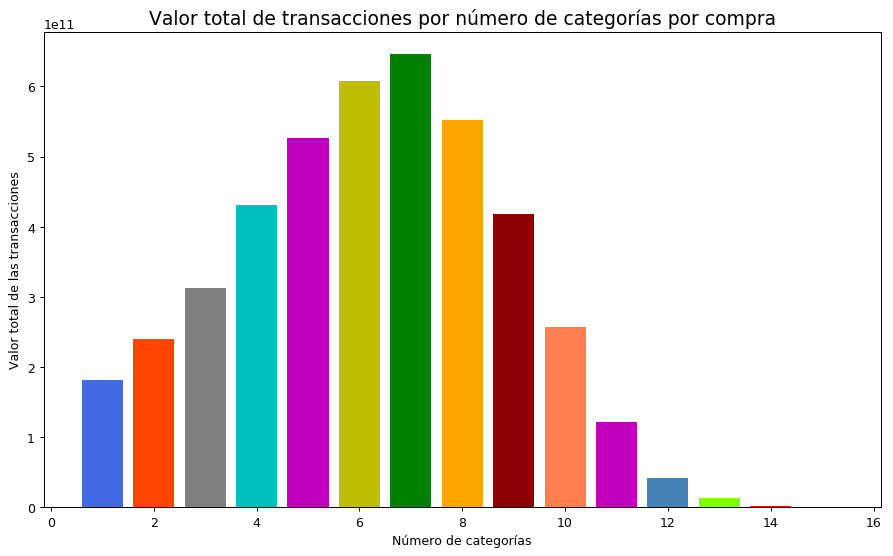

In [132]:
import pandas as pd
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(12, 7), dpi=90, facecolor='w', edgecolor='k')
import matplotlib.pyplot as plt

df = pd.read_csv('graficos_dashboard/clientes_monto_categoria.csv', header=None, names=None)


ax = fig.add_subplot(111)
ax.set_title('Valor total de transacciones por número de categorías por compra',fontsize=15)
ax.set_xlabel('Número de categorías')
ax.set_ylabel('Valor total de las transacciones')

colors = ['royalblue', 'orangered', 'gray', 'c', 'm', 'y', 'g','orange', 'darkred', 'coral', 'm', 'steelblue', 'chartreuse', 'r','magenta']

#ax.grid(color='b', linewidth=0.1)

plt.bar(df[0].tolist(),df[1].tolist(),color=colors)

plt.show()


____

## Número de transacciones por categoría

In [133]:
sql = spark.sql("""
                 SELECT categoria, COUNT(*) as trx 
                 FROM tabla 
                 WHERE categoria != "NONE"
                 GROUP BY categoria 
                 ORDER BY trx"""
               )

!rm -rf demo
sql.write.save('tables/demo', format="csv")
!cat tables/demo/part* > graficos_dashboard/trx_categoria.csv
!rm -rf demo

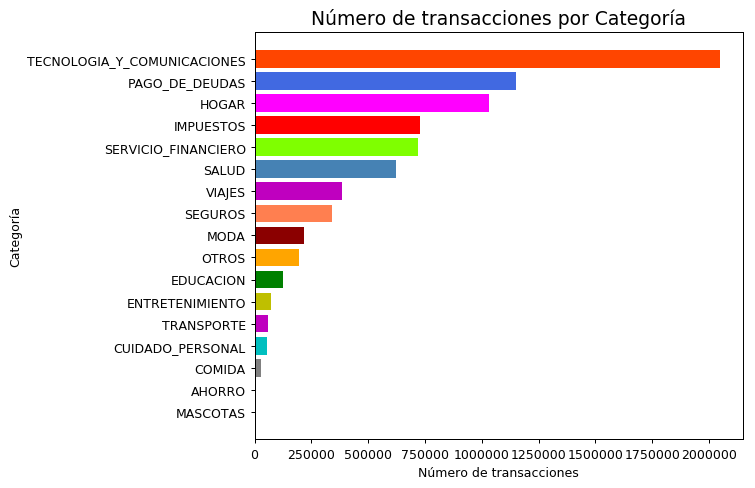

In [138]:
fig = figure(num=None, figsize=(7, 6), dpi=90, facecolor='w', edgecolor='k')
df = pd.read_csv("graficos_dashboard/numero_trx_categoria.csv", header=None)
colors = ['royalblue', 'orangered', 'gray', 'c', 'm', 'y', 'g','orange', 'darkred', 'coral', 'm', 'steelblue', 'chartreuse', 'r','magenta']

ax = fig.add_subplot(111)
ax.set_title('Número de transacciones por Categoría',fontsize=15)
ax.set_xlabel('Número de transacciones')
ax.set_ylabel('Categoría')
#ax.grid(color='b', linewidth=0.1)

plt.barh(df[0].tolist(),df[1].tolist(), color = colors)
plt.xticks(rotation=0)
plt.show()

____

### Valor total de transacciones por categoría

In [140]:
sql = spark.sql("""
                 SELECT categoria, SUM(valor_trx) as trx 
                 FROM tabla 
                 WHERE categoria != "NONE"
                 GROUP BY categoria 
                 ORDER BY trx"""
               )

!rm -rf demo
sql.write.save('tables/demo', format="csv")
!cat tables/demo/part* > graficos_dashboard/monto_trx_categoria.csv
!rm -rf demo


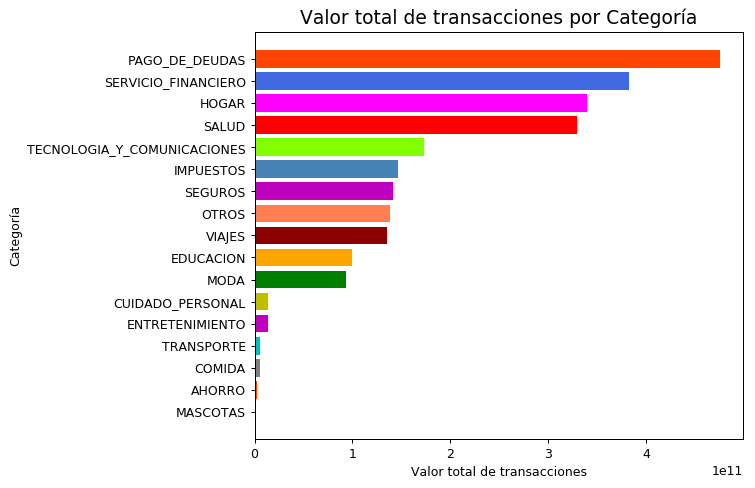

In [142]:
fig = figure(num=None, figsize=(7, 6), dpi=90, facecolor='w', edgecolor='k')
df = pd.read_csv("graficos_dashboard/monto_trx_categoria.csv", header=None)
colors = ['royalblue', 'orangered', 'gray', 'c', 'm', 'y', 'g','orange', 'darkred', 'coral', 'm', 'steelblue', 'chartreuse', 'r','magenta']

ax = fig.add_subplot(111)
ax.set_title('Valor total de transacciones por Categoría',fontsize=15)
ax.set_xlabel('Valor total de transacciones')
ax.set_ylabel('Categoría')

plt.barh(df[0].tolist(),df[1].tolist(), color = colors)
plt.xticks(rotation=0)
plt.show()

___

## Comportamiento del valor total por mes por categoria

In [102]:
sql = spark.sql("""
                SELECT categoria, YEAR(fecha) as ano, MONTH(fecha) as mes, sum(int(valor_trx))
                FROM tabla
                WHERE categoria = "EDUCACION" OR categoria = "IMPUESTOS"
                GROUP BY categoria, YEAR(fecha), MONTH(fecha) 
                ORDER BY categoria,ano, mes
                 """)
!rm -rf tables
sql.write.save('tables/demo', format="csv")
!cat tables/demo/part* > evo_mes_categoria.csv
!rm -rf demo

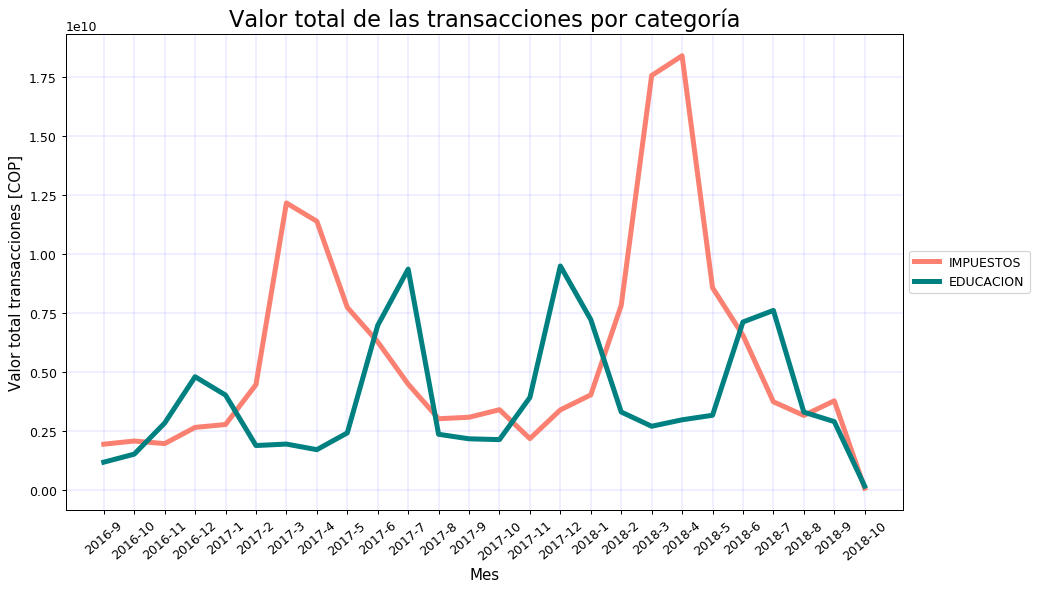

In [106]:
fig = figure(num=None, figsize=(15, 7), dpi=90, facecolor='w', edgecolor='k')
cat = ['IMPUESTOS','EDUCACION']
ax = fig.add_subplot(111)
colors = ["salmon","teal"]  
#df = pd.read_csv("evo_mes_categoria.csv", header=None,names=['categoria','año', 'mes','valor'])

for i in range(len(cat)):   
    
    df = pd.read_csv("evo_mes_categoria.csv", header=None,names=['categoria','año', 'mes','valor'])
    df = df.sort_values(by=['año','mes'],ascending=True)
    df["anomes"] = df["año"].map(str) + "-" +df["mes"].map(str)
    df = df[df['categoria']==cat[i]]
    df = df[['anomes', 'valor']]
    
    plt.xticks(rotation=40)
    ax.plot(df['anomes'].tolist(),df['valor'].tolist(), label=cat[i],linewidth=4.0,color=colors[i])
    
ax.set_title('Valor total de las transacciones por categoría',fontsize =18)
ax.set_xlabel('Mes',fontsize=12)
ax.set_ylabel('Valor total transacciones [COP]',fontsize=12)
ax.grid(color='b', linewidth=0.1)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

____

________________________________________________________________

### Consulta de valores de referencia en tabla original

In [ ]:
%%timeit -r1 -n1
infile = open('pse_sin_tratar.csv', 'r')
outfile = open('pse_sin_tratar2.csv', 'w')
for row in infile:
    row = row.replace(r'\N', 'vaciote')
    outfile.write(row)
infile.close()
outfile.close()

In [108]:
schema = StructType([
    StructField("id_trx",    StringType(), True),
    StructField("id_client", StringType(), True),
    StructField("fecha",     StringType(), True),
    StructField("hora",      StringType(), True),
    StructField("valor_trx", DoubleType(),  True),
    StructField("ref1", StringType(), True),
    StructField("ref2", StringType(), True),
    StructField("ref3", StringType(), True),
    StructField("sector", StringType(), True),
    StructField("subsector", StringType(), True),
    StructField("descripcion", StringType(), True)])


df = spark.read.load("pse_sin_tratar2.csv",
                     format="csv", 
                     sep=",", 
                     schema=schema, 
                     header="false")

df.createOrReplaceTempView("tabla")

#### Número de transacciones con sector definidio

In [88]:
sql = spark.sql("""
                 SELECT count(*)
                 FROM tabla
                 WHERE sector != "vaciote"
                 """
               )

In [89]:
sql.collect()

[Row(count(1)=3311010)]

#### numero de transacciones que tenían subsector 

In [96]:
sql = spark.sql("""
                 SELECT count(*)
                 FROM tabla
                 WHERE subsector != "vaciote"
                 """
               )

In [143]:
3311010

3311010

#### Número de registros con ref1

In [109]:
sql = spark.sql("""
                 SELECT count(*)
                 FROM tabla
                 WHERE ref1 != "vaciote"
                 """
               )

In [110]:
sql.show()

+--------+
|count(1)|
+--------+
|11491873|
+--------+



#### Número de registros con ref2

In [111]:
sql = spark.sql("""
                 SELECT count(*)
                 FROM tabla
                 WHERE ref2 != "vaciote"
                 """
               )
sql.show()

+--------+
|count(1)|
+--------+
| 6797834|
+--------+



#### Número de registros con ref3

In [120]:
sql = spark.sql("""
                 SELECT count(*)
                 FROM tabla
                 where ref3 != "vaciote"
            
                 """
               )
sql.show()

+--------+
|count(1)|
+--------+
|       0|
+--------+

